In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from models import create_model 
import pandas as pd

import yaml
import torch
from pipeline.walkforward import WFCVGenerator
from utils.paths import CONFIG_DIR, VOL_EXPERIMENTS_DIR, DATA_DIR, PRICE_EXPERIMENTS_DIR

from config.config_types import AppConfig


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import json


In [3]:

fold_num = 0
name = "exp_001_mlp_40_sliding"
name = "exp_010_cnn_40_sliding"
name = "exp_006_cnn_40"
name = "exp_012_cnn_40"
name = "exp_011_mlp_40"
name = "exp_013_mlp_504"
name = "exp_011_mlp_40"

name  = "exp_012_lstm_40"
name  = "exp_017_debug"
trial = "trial_20251108_145907" 
trial = "trial_20251108_010740" 

# -------- load config --------
base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
conifg_path = f"{base}config_snapshot.json"

with open(conifg_path, 'r') as f:
    cfg = json.load(f)

cfg = cfg["cfg"]

cfg = AppConfig.from_dict(cfg)

if cfg.data["df_master"] is not None:
    df_master_path =  cfg.data["df_master"]
    df_master = pd.read_parquet(f"{DATA_DIR}/{df_master_path}")
    #print(f"provided df master: {df_master_path}\n{df_master.head()}")
else:
    df_master = None

wf = WFCVGenerator(config=cfg.walkforward)


In [4]:
results = pd.read_csv(f"{base}/results.csv")
results


,trial,fold,tr_loss,val_loss,test_loss,tr_mae,val_mae,test_mae,tr_directional_accuracy_pct,val_directional_accuracy_pct,test_directional_accuracy_pct,seconds,model_path
0,0,0,0.43046,0.423086,0.379629,0.510972,0.505036,0.482202,78.274624,77.894052,73.287476,2915.541626,/orcd/home/002/corte911/code/finNN_code/src/vo...


In [5]:
results.drop(columns="model_path").mean().apply(lambda x: round(x, 5))

trial                               0.00000
fold                                0.00000
tr_loss                             0.43046
val_loss                            0.42309
test_loss                           0.37963
tr_mae                              0.51097
val_mae                             0.50504
test_mae                            0.48220
tr_directional_accuracy_pct        78.27462
val_directional_accuracy_pct       77.89405
test_directional_accuracy_pct      73.28748
seconds                          2915.54163
dtype: float64

In [6]:

test_data = {}
data = {}
for i, fold_data in enumerate(wf.folds()):
    X_test = fold_data[4]
    y_test = fold_data[5]

    test_data[i] = [X_test, y_test]
    data[i] = fold_data
    print(i)
    #if i == fold_num:
    #    break


0


In [15]:
pd.DataFrame(X_test).describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,...,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000,564795.000000
mean,0.001721,0.003567,0.004945,0.006481,0.007094,0.007626,0.008240,0.008544,0.008935,0.009592,...,-0.018445,-0.018879,-0.019435,-0.020020,-0.020394,-0.021103,-0.021129,-0.021199,-0.020879,-0.021078
std,0.865167,0.864325,0.863501,0.862419,0.861983,0.861374,0.860719,0.860532,0.860246,0.859803,...,0.815764,0.815606,0.815465,0.815357,0.815082,0.814404,0.813614,0.813083,0.812667,0.812161
min,-3.886998,-3.889607,-3.893078,-3.894139,-3.895273,-3.896297,-3.896574,-3.898155,-3.898549,-3.898958,...,-4.065607,-4.065357,-4.064471,-4.063811,-4.062625,-4.061324,-4.059636,-4.057554,-4.055206,-4.052044
25%,-0.591797,-0.590145,-0.588632,-0.586795,-0.585944,-0.585074,-0.584120,-0.583752,-0.583254,-0.582403,...,-0.581015,-0.581373,-0.581913,-0.582482,-0.582607,-0.582644,-0.582115,-0.581631,-0.580942,-0.580752
50%,-0.051878,-0.049788,-0.048064,-0.046086,-0.045160,-0.044262,-0.043415,-0.042869,-0.042352,-0.041577,...,-0.051091,-0.051514,-0.052183,-0.052839,-0.053253,-0.053861,-0.053563,-0.053637,-0.053210,-0.053605
75%,0.531180,0.533595,0.535247,0.536869,0.537891,0.538737,0.539466,0.540082,0.540610,0.541237,...,0.509172,0.508736,0.508004,0.507271,0.506663,0.505387,0.505363,0.504899,0.504877,0.504310
max,3.973790,3.978358,3.981795,3.984732,3.987731,3.990666,3.992797,3.995695,3.997888,4.000117,...,4.114780,4.115062,4.114297,4.114052,4.113433,4.112569,4.111615,4.110120,4.108821,4.106574


In [7]:


hparams = cfg.model.hparams
input_shape = (cfg.walkforward.lags,)
output_shape = cfg.walkforward.lookback+1

ckpt_path = f"{base}fold_{fold_num:03d}/model_best.pt"
checkpoint = torch.load(ckpt_path, map_location="cuda")




In [20]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

sns.set_theme(style="darkgrid", context="talk")

def maybe_inverse(y, scaler):
    return y if scaler is None else scaler.inverse_transform(y.reshape(-1,1)).ravel()


def _prepare_X_for_ols(X: np.ndarray) -> np.ndarray:
    """Flatten to (N, F) for LinearRegression. Handles (N,), (N,T), (N,T,D)."""
    X = np.asarray(X)
    if X.ndim == 1:
        return X.reshape(-1, 1)
    if X.ndim == 2:
        return X
    if X.ndim == 3:
        N, T, D = X.shape
        return X.reshape(N, T*D)
    raise ValueError(f"Unexpected X shape for OLS: {X.shape}")



def plot_split_dims_dual(title, y_true, y_pred_nn, y_pred_ols):
    """
    Side-by-side comparison of NN vs OLS:
    - Figure 1: Scatter + 45° + per-panel linear fit (red) for each model
    - Figure 2: KDE of true vs predicted for each model
    Works for 1-D or multi-D targets.
    """
    y_true     = np.asarray(y_true)
    y_pred_nn  = np.asarray(y_pred_nn)
    y_pred_ols = np.asarray(y_pred_ols)

    # Ensure 2D: (N,) -> (N,1)
    if y_true.ndim == 1:      y_true = y_true.reshape(-1, 1)
    if y_pred_nn.ndim == 1:   y_pred_nn = y_pred_nn.reshape(-1, 1)
    if y_pred_ols.ndim == 1:  y_pred_ols = y_pred_ols.reshape(-1, 1)

    assert y_true.shape == y_pred_nn.shape == y_pred_ols.shape, \
        "y_true, y_pred_nn, y_pred_ols must have the same shape"
    _, K = y_true.shape

    def _fit_stats(yt, yp):
        reg = LinearRegression().fit(yt.reshape(-1,1), yp)
        slope, intercept = reg.coef_[0], reg.intercept_
        r2   = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        return reg, slope, intercept, r2, rmse

    # ---------- SINGLE-OUTPUT ----------
    if K == 1:
        yt = y_true[:, 0]
        yp_nn  = y_pred_nn[:, 0]
        yp_ols = y_pred_ols[:, 0]

        lo = min(yt.min(), yp_nn.min(), yp_ols.min())
        hi = max(yt.max(), yp_nn.max(), yp_ols.max())
        pad = 0.02 * (hi - lo); lo -= pad; hi += pad
        x_line = np.linspace(lo, hi, 200)

        reg_nn, slope_nn, int_nn, r2_nn, rmse_nn = _fit_stats(yt, yp_nn)
        y_line_nn  = reg_nn.predict(x_line.reshape(-1,1))

        reg_ols, slope_ols, int_ols, r2_ols, rmse_ols = _fit_stats(yt, yp_ols)
        y_line_ols = reg_ols.predict(x_line.reshape(-1,1))

        # Scatter panels (NN | OLS)
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), squeeze=False)
        axL, axR = axes[0]

        axL.scatter(yt, yp_nn, s=8, alpha=0.5, edgecolors="none")
        axL.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axL.plot(x_line, y_line_nn, 'r-', lw=2, label=f'Fit: y={slope_nn:.3f}x+{int_nn:.3f}')
        axL.set_title(f"NN — R²={r2_nn:.5f}, RMSE={rmse_nn:.5g}")
        axL.set_xlabel("True"); axL.set_ylabel("Predicted")
        axL.set_xlim(lo, hi); axL.set_ylim(lo, hi); axL.legend()

        axR.scatter(yt, yp_ols, s=8, alpha=0.5, edgecolors="none")
        axR.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axR.plot(x_line, y_line_ols, 'r-', lw=2, label=f'Fit: y={slope_ols:.3f}x+{int_ols:.3f}')
        axR.set_title(f"OLS — R²={r2_ols:.5f}, RMSE={rmse_ols:.5g}")
        axR.set_xlabel("True"); axR.set_ylabel("Predicted")
        axR.set_xlim(lo, hi); axR.set_ylim(lo, hi); axR.legend()

        fig.suptitle(f"{title} — Scatter & Fit (NN vs OLS)", y=0.98, fontsize=14)
        fig.tight_layout(); plt.show()

        # KDE panels (NN | OLS)
        fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5), squeeze=False)
        axL, axR = axes2[0]

        sns.kdeplot(yt,    fill=True, alpha=0.4, label="True",      linewidth=2, ax=axL)
        sns.kdeplot(yp_nn, fill=True, alpha=0.4, label="Predicted", linewidth=2, ax=axL)
        axL.set_title("Distributions — NN");  axL.set_xlim(lo, hi); axL.legend()

        sns.kdeplot(yt,     fill=True, alpha=0.4, label="True",      linewidth=2, ax=axR)
        sns.kdeplot(yp_ols, fill=True, alpha=0.4, label="Predicted", linewidth=2, ax=axR)
        axR.set_title("Distributions — OLS"); axR.set_xlim(lo, hi); axR.legend()

        fig2.suptitle(f"{title} — Distributions (NN vs OLS)", y=0.98, fontsize=14)
        fig2.tight_layout(); plt.show()
        return

    # ---------- MULTI-OUTPUT ----------
    nrows, ncols_dim = K, 2  # per-dim rows, columns = [NN | OLS]

    # Scatter grid
    fig_scatter, axes_s = plt.subplots(nrows, ncols_dim,
                                       figsize=(12, 5*nrows), squeeze=False)

    for j in range(K):
        yt = y_true[:, j]
        yp_nn  = y_pred_nn[:, j]
        yp_ols = y_pred_ols[:, j]

        lo = min(yt.min(), yp_nn.min(), yp_ols.min())
        hi = max(yt.max(), yp_nn.max(), yp_ols.max())
        pad = 0.02 * (hi - lo); lo -= pad; hi += pad
        x_line = np.linspace(lo, hi, 200)

        reg_nn, slope_nn, int_nn, r2_nn, rmse_nn = _fit_stats(yt, yp_nn)
        y_line_nn  = reg_nn.predict(x_line.reshape(-1,1))

        reg_ols, slope_ols, int_ols, r2_ols, rmse_ols = _fit_stats(yt, yp_ols)
        y_line_ols = reg_ols.predict(x_line.reshape(-1,1))

        axL = axes_s[j, 0]
        axL.scatter(yt, yp_nn, s=8, alpha=0.5, edgecolors="none")
        axL.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axL.plot(x_line, y_line_nn, 'r-', lw=2, label=f'Fit: y={slope_nn:.3f}x+{int_nn:.3f}')
        axL.set_title(f"Dim {j} — NN (R²={r2_nn:.5f}, RMSE={rmse_nn:.5g})")
        axL.set_xlabel("True"); axL.set_ylabel("Predicted")
        axL.set_xlim(lo, hi); axL.set_ylim(lo, hi); axL.legend(loc="best")

        axR = axes_s[j, 1]
        axR.scatter(yt, yp_ols, s=8, alpha=0.5, edgecolors="none")
        axR.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axR.plot(x_line, y_line_ols, 'r-', lw=2, label=f'Fit: y={slope_ols:.3f}x+{int_ols:.3f}')
        axR.set_title(f"Dim {j} — OLS (R²={r2_ols:.5f}, RMSE={rmse_ols:.5g})")
        axR.set_xlabel("True"); axR.set_ylabel("Predicted")
        axR.set_xlim(lo, hi); axR.set_ylim(lo, hi); axR.legend(loc="best")

    fig_scatter.suptitle(f"{title} — Scatter & Fit per Dim (NN vs OLS)", y=0.995, fontsize=14)
    fig_scatter.tight_layout(); plt.show()

    # KDE grid
    fig_kde, axes_k = plt.subplots(nrows, ncols_dim,
                                   figsize=(12, 4*nrows), squeeze=False)
    for j in range(K):
        yt = y_true[:, j]
        yp_nn  = y_pred_nn[:, j]
        yp_ols = y_pred_ols[:, j]
        lo = min(yt.min(), yp_nn.min(), yp_ols.min())
        hi = max(yt.max(), yp_nn.max(), yp_ols.max())
        pad = 0.02 * (hi - lo); lo -= pad; hi += pad

        axL = axes_k[j, 0]
        sns.kdeplot(yt,    fill=True, alpha=0.5, label="True",      linewidth=2, ax=axL)
        sns.kdeplot(yp_nn, fill=True, alpha=0.5, label="Predicted", linewidth=2, ax=axL)
        axL.set_title(f"KDE — Dim {j} (NN)")
        axL.set_xlim(lo, hi); axL.legend(loc="best")

        axR = axes_k[j, 1]
        sns.kdeplot(yt,     fill=True, alpha=0.5, label="True",      linewidth=2, ax=axR)
        sns.kdeplot(yp_ols, fill=True, alpha=0.5, label="Predicted", linewidth=2, ax=axR)
        axR.set_title(f"KDE — Dim {j} (OLS)")
        axR.set_xlim(lo, hi); axR.legend(loc="best")

    fig_kde.suptitle(f"Distributions — {title} (NN vs OLS)", y=0.995, fontsize=14)
    fig_kde.tight_layout(); plt.show()

def _infer_lstm_input_size_from_ckpt(state_dict: dict) -> int | None:
    # look for first LSTM weight_ih
    for k, v in state_dict.items():
        if k.endswith("lstm_layers.0.weight_ih_l0") or ("lstm_layers.0.weight_ih_l0" in k):
            # shape is [4*H, input_size]
            return int(v.shape[1])
    # legacy single-module naming (if any)
    for k, v in state_dict.items():
        if k.endswith("lstm.weight_ih_l0") or ("lstm.weight_ih_l0" in k):
            return int(v.shape[1])
    return None

def _make_input_shape_for_eval(cfg, X_sample: torch.Tensor | np.ndarray, state_dict: dict):
    name = cfg.model.name.lower()
    # infer T and (optional) D from the data
    if isinstance(X_sample, np.ndarray):
        shape = X_sample.shape
    else:
        shape = tuple(X_sample.shape)
    # shape is typically (N, T) or (N, T, D)
    if len(shape) == 2:
        _, T = shape
        D_data = 1
    elif len(shape) == 3:
        _, T, D_data = shape
    else:
        raise ValueError(f"Unexpected batch shape for X: {shape}")

    if name == "lstm":
        D_ckpt = _infer_lstm_input_size_from_ckpt(state_dict)
        D = D_ckpt if D_ckpt is not None else D_data  # prefer ckpt
        return (T, D)
    elif name == "simplecnn":
        # your CNN expects (C, L) with C=1
        return (1, T)
    elif name == "mlp":
        # your MLP code expects (T,) as before (flattened window)
        return (T,)
    else:
        raise ValueError(f"Unknown model name: {cfg.model.name}")

@torch.inference_mode()
def _predict_batched(model, X, device="cuda", bs=8192):
    preds = []
    for i in range(0, len(X), bs):
        xb = torch.as_tensor(X[i:i+bs], dtype=torch.float32, device=device)
        pb = model(xb).detach().cpu()
        preds.append(pb)
    return torch.cat(preds, dim=0).numpy()

def eval_and_plot_simple(cfg, input_shape, output_shape, ckpt, datasets, device="cuda"):
    Xtr, ytr, Xv, yv, Xte, yte = datasets

    # strip compile prefix if present
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in ckpt["model_state"].items()}

    # build the **correct** input_shape for this checkpoint + data
    input_shape = _make_input_shape_for_eval(cfg, Xtr, state_dict)

    # (optional) infer output_dim from head if you want to be robust
    # otherwise keep your existing output_shape
    # try to find last linear in head
    out_dim = None
    for k, v in state_dict.items():
        if k.startswith("head.") and k.endswith(".weight"):
            if out_dim is None or v.shape[0] < out_dim:
                out_dim = int(v.shape[0])
    if out_dim is not None:
        output_shape = out_dim

    def make_input_shape(c):
        if cfg.model.name.lower() == "mlp":
            return (c.walkforward.lags, )
        elif cfg.model.name.lower() == "simplecnn":
            return (1, cfg.walkforward.lags)  # (C, L)
        elif cfg.model.name.lower() == "lstm":
            return (cfg.walkforward.lags, 1)
        else:
            print(f"Model: {cfg.model.name} not recognized!")
            raise ValueError

    # ouput shape is constant
    output_shape = cfg.walkforward.lookback + 1 if cfg.walkforward.lookback is not None else 1

    # rebuild & load model
    model = create_model(cfg.model, input_shape, output_shape)
    model.load_state_dict(state_dict, strict=True)
    model.to(device).eval()

    # predictions (batched to avoid OOM)
    yhat_tr = _predict_batched(model, Xtr, device=device, bs=8192)
    yhat_v  = _predict_batched(model, Xv,  device=device, bs=8192)
    yhat_te = _predict_batched(model, Xte, device=device, bs=8192)

    # --- OLS baseline on TRAIN, predict on all splits ---
    Xtr_lin = _prepare_X_for_ols(Xtr)
    Xv_lin  = _prepare_X_for_ols(Xv)
    Xte_lin = _prepare_X_for_ols(Xte)

    # LinearRegression supports multi-output y directly
    ols = LinearRegression(fit_intercept=True).fit(Xtr_lin, ytr)
    yhat_tr_ols = ols.predict(Xtr_lin)
    yhat_v_ols  = ols.predict(Xv_lin)
    yhat_te_ols = ols.predict(Xte_lin)

    # numpy true arrays
    ytr = np.asarray(ytr, dtype=np.float32)
    yv  = np.asarray(yv,  dtype=np.float32)
    yte = np.asarray(yte, dtype=np.float32)

    print("Train", ytr.shape, yhat_tr.shape, yhat_tr_ols.shape)

    # --- Dual plots (NN vs OLS) ---
    plot_split_dims_dual("Train",      ytr, yhat_tr, yhat_tr_ols)
    plot_split_dims_dual("Validation", yv,  yhat_v,  yhat_v_ols)
    plot_split_dims_dual("Test",       yte, yhat_te, yhat_te_ols)


    return model, (ytr, yhat_tr), (yv, yhat_v), (yte, yhat_te)


Train (1723450,) (1723450, 1) (1723450,)


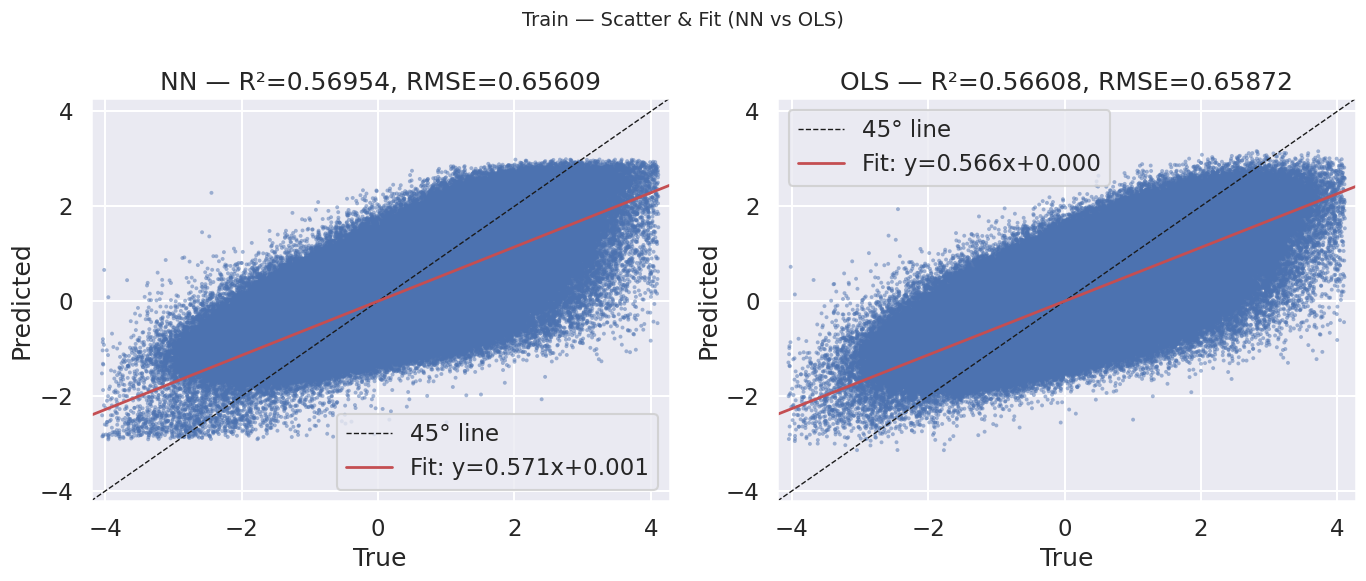

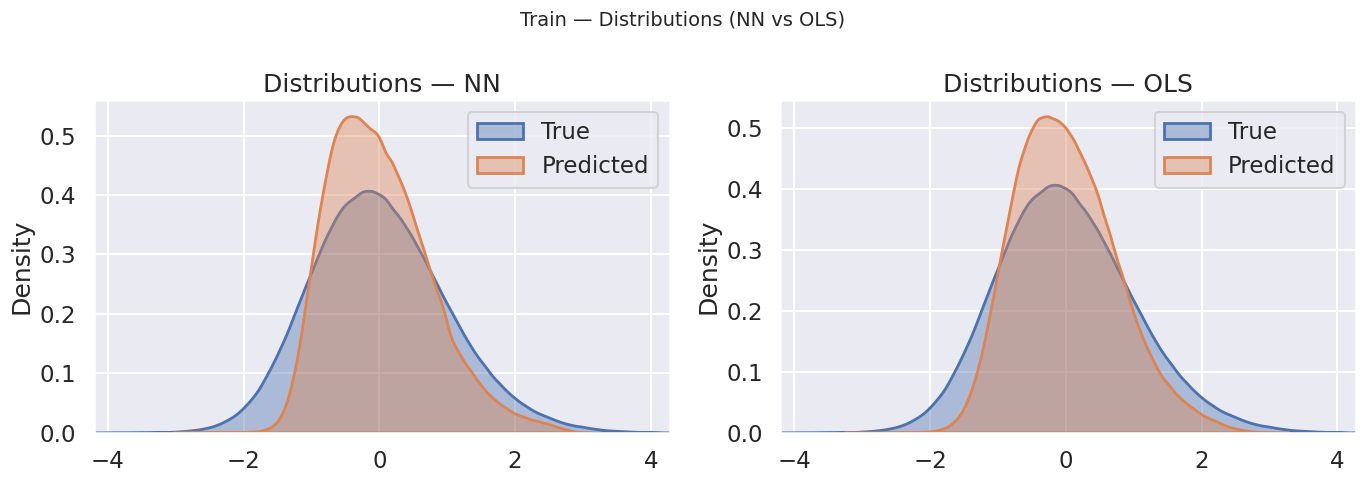

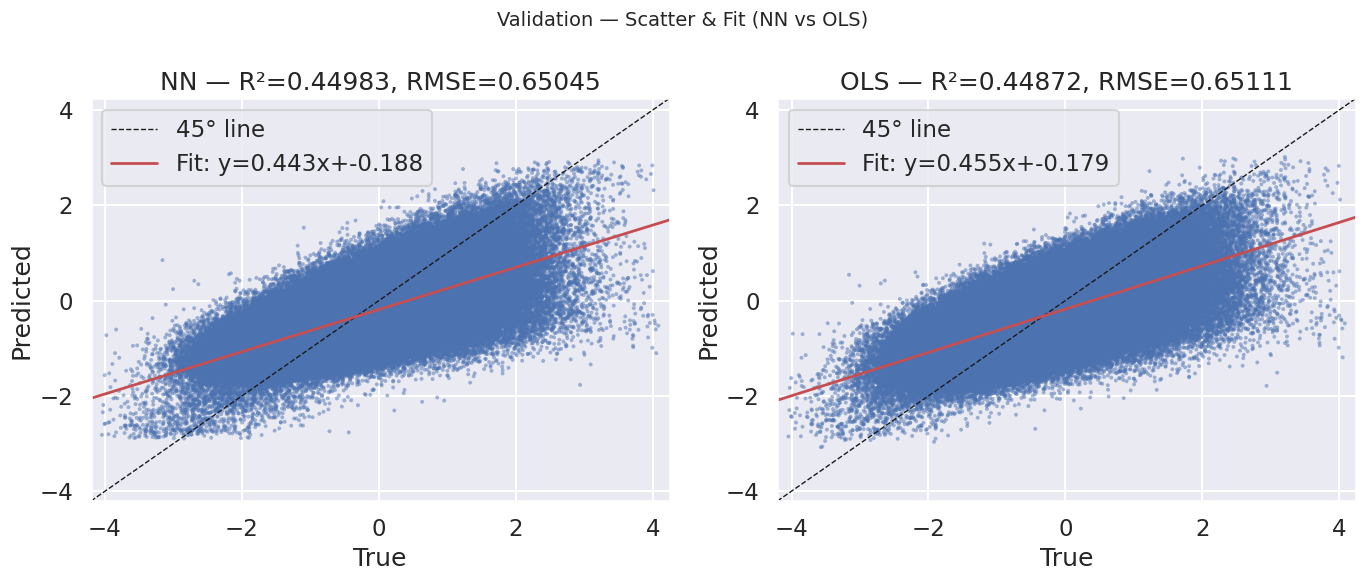

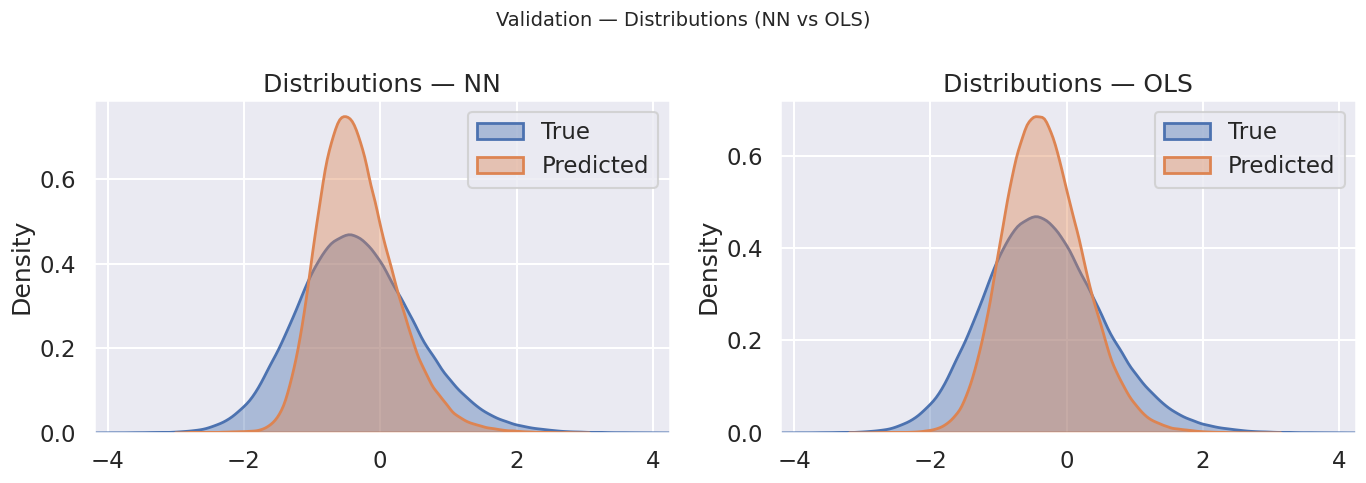

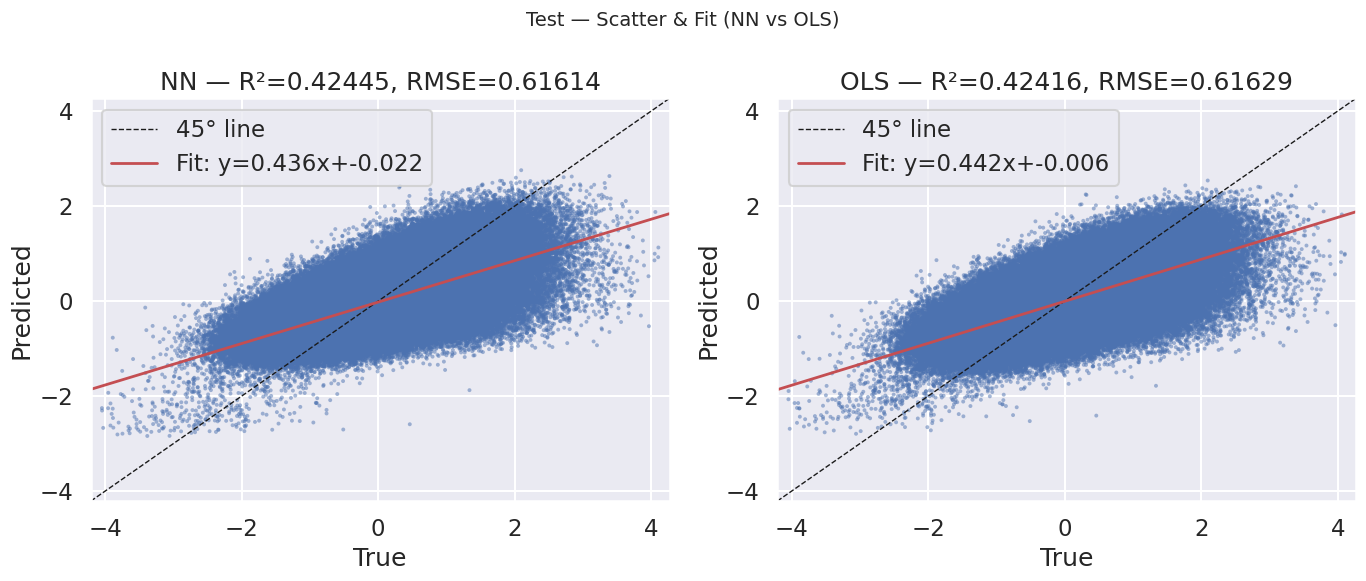

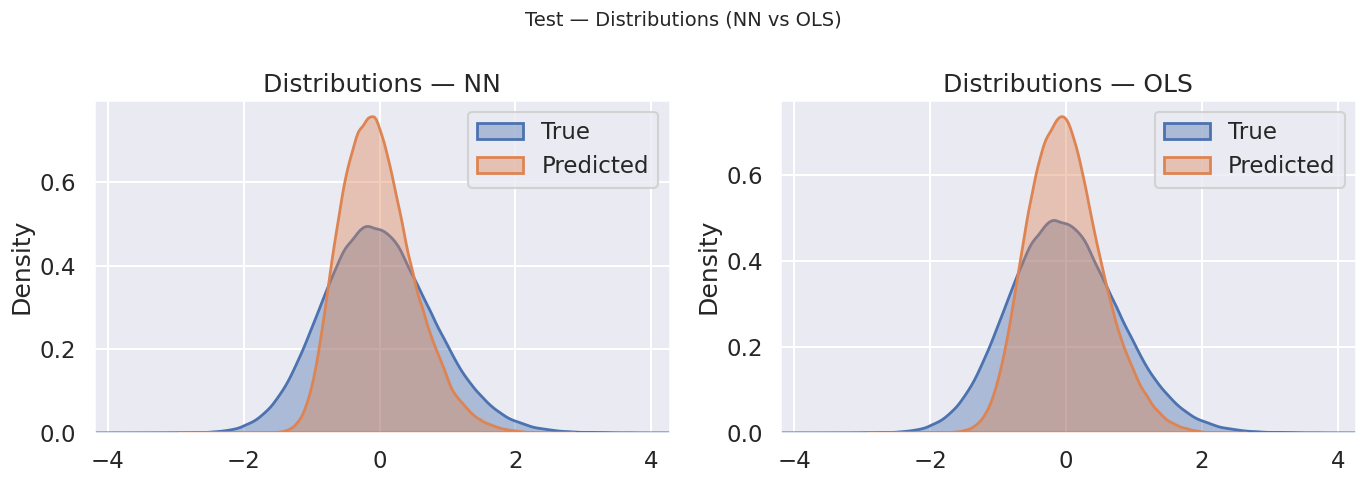

In [21]:
# old lines (now simplified)
model, trdata, vdata, tedata = eval_and_plot_simple(
    cfg,
    input_shape=None,         # you can even pass None now — it’s inferred
    output_shape=None,        # optional, inferred if missing
    ckpt=checkpoint,
    datasets=data[fold_num],
    device="cuda"
)


In [10]:
fold = 0
while True:    
    print("-"*50)
    print(f'fold: {fold}')
    try:
        for arr in data[fold]:
            print(f"{np.mean(arr):.4f}, {np.std(arr):.4f}, {np.percentile(arr, q=[0.05, 0.25, 0.5, 0.75, 0.95])},{np.min(arr):.4f}, {np.max(arr):.4f}")
        fold +=1
    except KeyError:
        break

--------------------------------------------------
fold: 0
0.0000, 1.0000, [-2.945663   -2.50181838 -2.30517383 -2.18668114 -2.1139623 ],-4.0717, 4.1226
-0.0000, 1.0000, [-3.09036938 -2.54797288 -2.3281023  -2.20328767 -2.12571384],-4.0488, 4.1117
-0.3656, 0.8679, [-2.97929538 -2.57900531 -2.4049193  -2.29714647 -2.23261163],-4.0515, 4.0925
-0.3411, 0.8769, [-3.12714452 -2.6360632  -2.43125094 -2.31488351 -2.24304854],-4.0454, 4.0818
0.0028, 0.8413, [-2.49396489 -2.12877774 -1.9636616  -1.86161541 -1.79931495],-4.0707, 4.1151
-0.0217, 0.8121, [-2.63768672 -2.15024772 -1.96669317 -1.86359685 -1.79732928],-4.0490, 4.1042
--------------------------------------------------
fold: 1


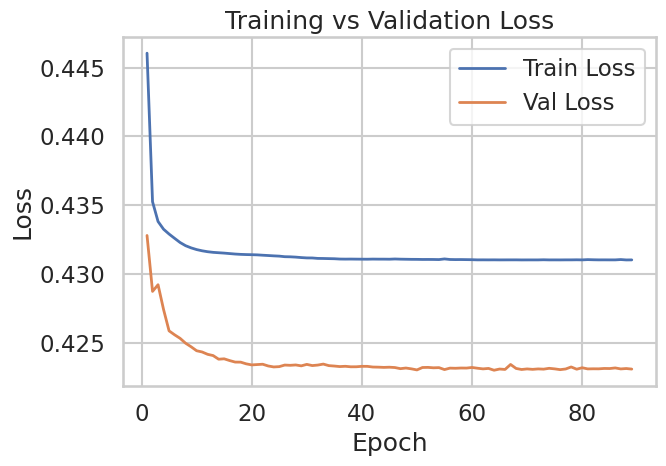

In [11]:
def plot_training_history(ckpt):
    """Plot train vs validation loss curves from the saved checkpoint."""
    history = ckpt.get("history", None)
    if not history:
        print("No training history found in checkpoint.")
        return

    # Convert list of dicts to separate arrays
    tr_losses = [h["tr_loss"] for h in history]
    val_losses = [h["val_loss"] for h in history]
    epochs = np.arange(1, len(tr_losses) + 1)

    sns.set_theme(style="whitegrid", context="talk")
    plt.figure(figsize=(7,5))
    plt.plot(epochs, tr_losses, label="Train Loss", lw=2)
    plt.plot(epochs, val_losses, label="Val Loss", lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(checkpoint)

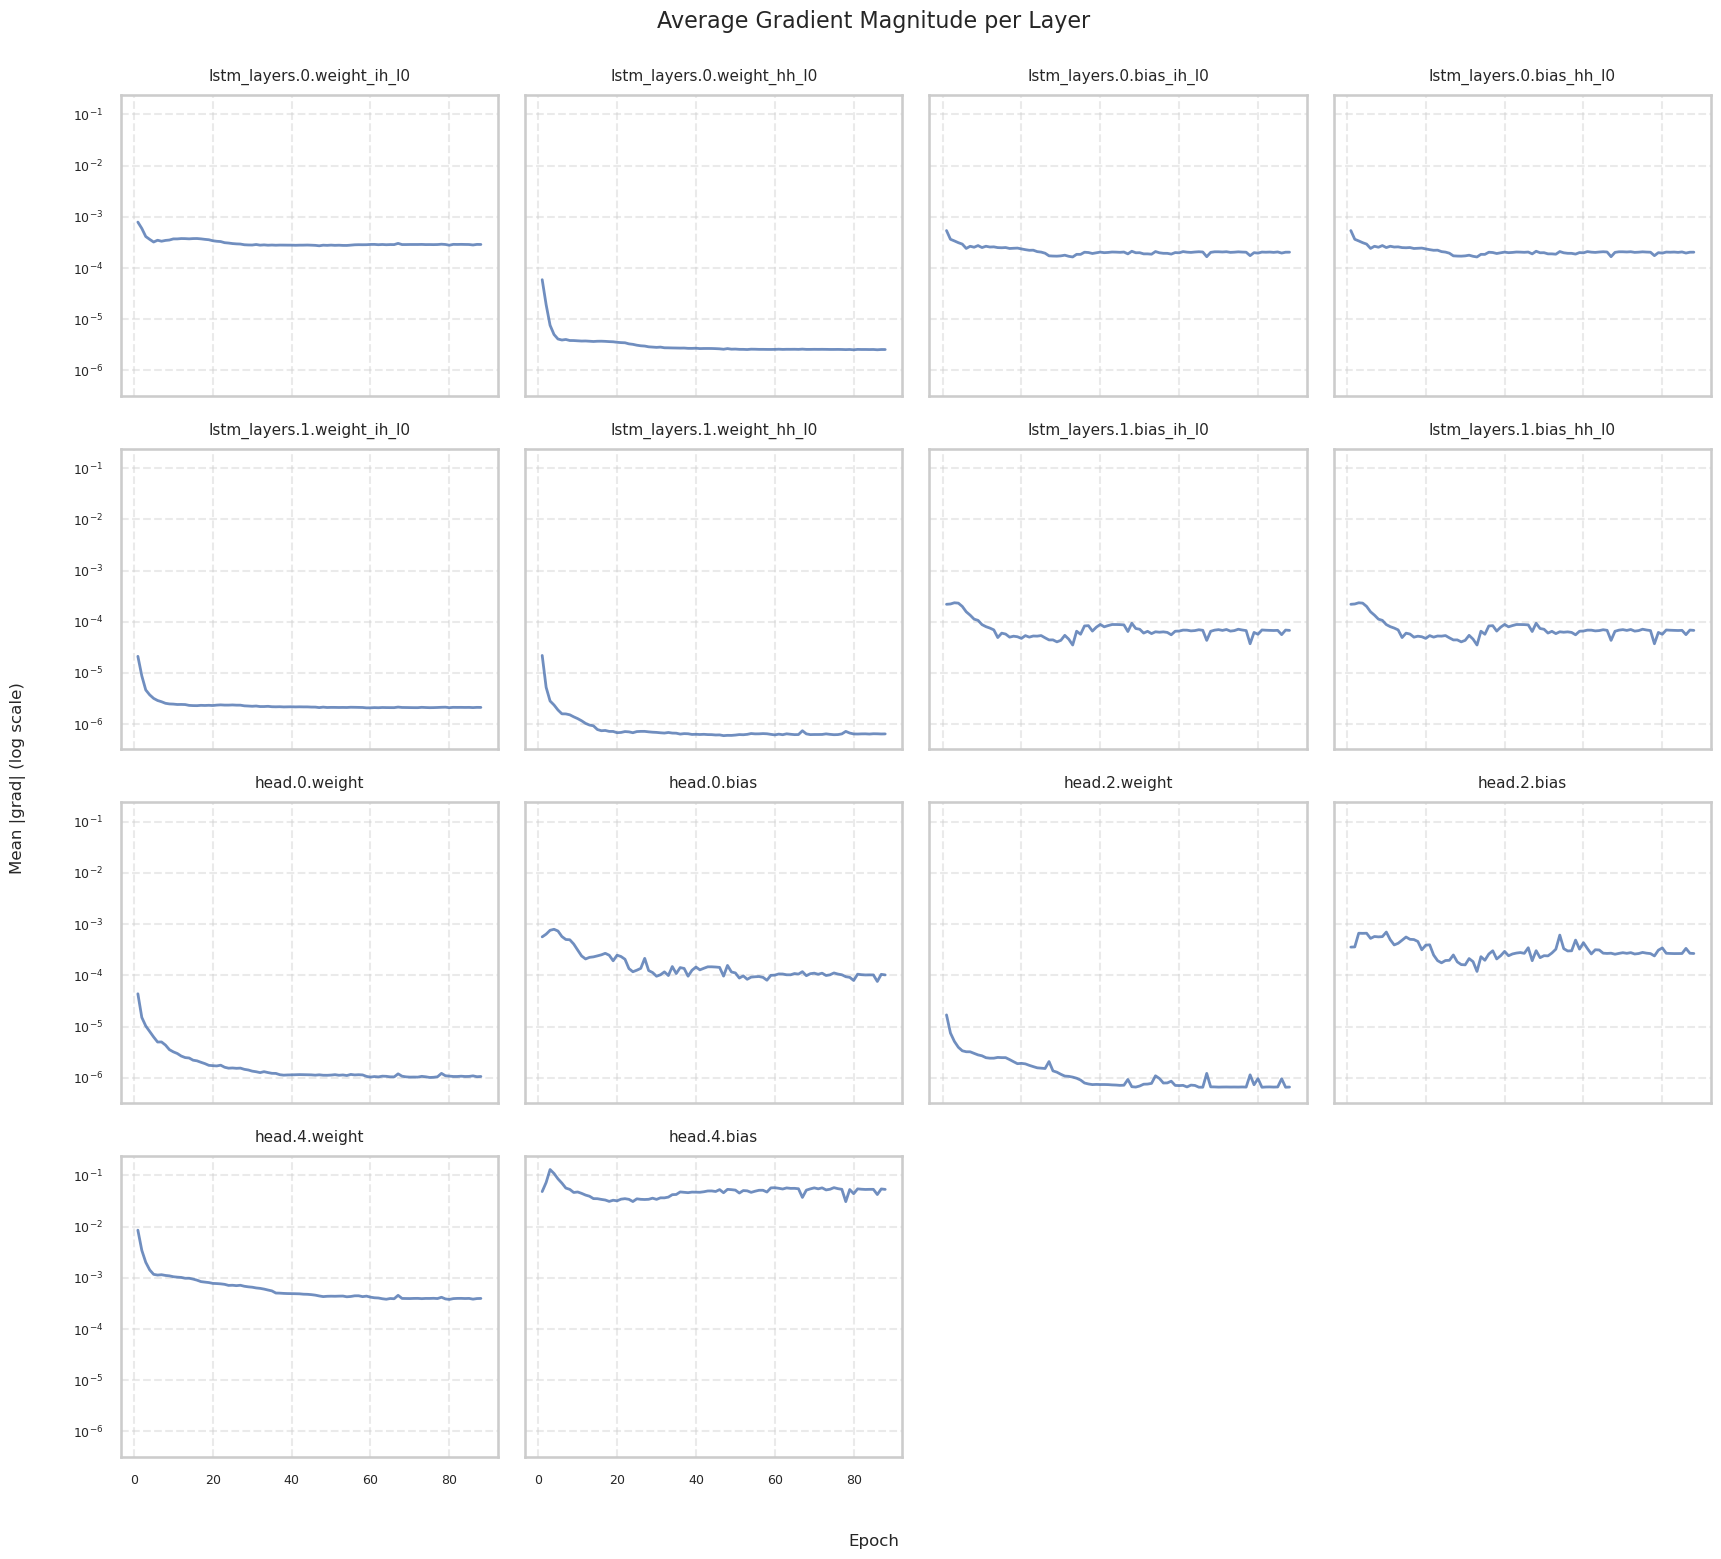

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import math

def plot_grad(ckpt):
    grad_history = ckpt.get("grad_history", [])
    if not grad_history:
        print("No grad_history found in checkpoint.")
        return

    df = pd.DataFrame(grad_history)
    if "epoch" not in df.columns:
        print("No 'epoch' column found in grad_history.")
        return

    df.set_index("epoch", inplace=True)
    
    # Clean column names for display (remove prefixes like _orig_mod.)
    df.columns = [c.replace("_orig_mod.", "") for c in df.columns]

    # --- grid setup ---
    n_cols = 4
    n_layers = len(df.columns)
    n_rows = math.ceil(n_layers / n_cols)

    # Increase figure size and adjust spacing
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        ax.plot(df.index, df[col], lw=2, alpha=0.8)
        ax.set_title(col, fontsize=11, pad=10)
        ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # Improve tick label formatting
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.tick_params(axis='both', which='minor', labelsize=7)
    
    # Hide empty tiles if #layers < grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout with more padding
    plt.tight_layout(rect=[0.04, 0.04, 0.98, 0.96])  # [left, bottom, right, top]
    
    # Add titles with proper positioning
    fig.suptitle("Average Gradient Magnitude per Layer", fontsize=16, y=0.98)
    fig.text(0.5, 0.02, "Epoch", ha="center", fontsize=12)
    fig.text(0.02, 0.5, "Mean |grad| (log scale)", va="center", rotation="vertical", fontsize=12)
    
    plt.show()

plot_grad(checkpoint)

In [13]:
ckpt = checkpoint
grad_history = ckpt.get("grad_history", [])

df = pd.DataFrame(grad_history)

df.set_index("epoch", inplace=True)

# Clean column names for display (remove prefixes like _orig_mod.)
df.columns = [c.replace("_orig_mod.", "") for c in df.columns]
df


,lstm_layers.0.weight_ih_l0,lstm_layers.0.weight_hh_l0,lstm_layers.0.bias_ih_l0,lstm_layers.0.bias_hh_l0,lstm_layers.1.weight_ih_l0,lstm_layers.1.weight_hh_l0,lstm_layers.1.bias_ih_l0,lstm_layers.1.bias_hh_l0,head.0.weight,head.0.bias,head.2.weight,head.2.bias,head.4.weight,head.4.bias
epoch,,,,,,,,,,,,,,
1,0.000789,0.000059,0.000540,0.000540,0.000021,2.193961e-05,0.000219,0.000219,0.000044,0.000565,1.690854e-05,0.000357,0.008525,0.048364
2,0.000594,0.000019,0.000365,0.000365,0.000009,5.230701e-06,0.000222,0.000222,0.000015,0.000638,7.480910e-06,0.000360,0.003437,0.072782
3,0.000413,0.000008,0.000339,0.000339,0.000005,2.827930e-06,0.000234,0.000234,0.000010,0.000759,5.132684e-06,0.000665,0.002008,0.130246
4,0.000363,0.000005,0.000313,0.000313,0.000004,2.364782e-06,0.000231,0.000231,0.000008,0.000794,3.947967e-06,0.000662,0.001428,0.109139
5,0.000323,0.000004,0.000294,0.000294,0.000003,1.888497e-06,0.000199,0.000199,0.000006,0.000735,3.369386e-06,0.000665,0.001169,0.085742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.000289,0.000003,0.000202,0.000202,0.000002,6.396149e-07,0.000067,0.000067,0.000001,0.000102,6.584410e-07,0.000267,0.000394,0.053446
85,0.000288,0.000003,0.000206,0.000206,0.000002,6.488783e-07,0.000068,0.000068,0.000001,0.000102,6.623234e-07,0.000267,0.000396,0.053466
86,0.000282,0.000003,0.000196,0.000196,0.000002,6.469025e-07,0.000056,0.000056,0.000001,0.000076,9.561285e-07,0.000336,0.000383,0.042340
